In [2]:
%load_ext autoreload
%autoreload 2

DATA_DIR = '../data/'

# Explore the columns of data and find outliers
import pandas as pd
import os.path as osp

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')

In [3]:
# Visualization libraries
from source.utils.visualization import *
SAVE_EXTENSION = '.pdf'
SAVE_DIR = '../figures/'

plot_kwargs = {
    "column" : "half",
    "nrows" : 1,
    "ncols" : 1,
    "usetex" : False
}
setup_plotting_icml2022(
    **plot_kwargs
    )

In [4]:
REFRESH_DATA = True
CHARTS_PATH = osp.join(DATA_DIR,'charts_processed.csv')
AUDIO_PATH = osp.join(DATA_DIR,'audio_features_processed.csv')

In [5]:
if REFRESH_DATA:

    # Load the datasets into dataframes. Read the date column as datetime.date
    charts_df = pd.read_csv(CHARTS_PATH, parse_dates=['date'])

charts_df['date'] = pd.to_datetime(charts_df['date'])

# Display the first few rows of the DataFrame to verify
charts_df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [6]:
if REFRESH_DATA:
    # Load the audio features dataset
    audio_df = pd.read_csv(AUDIO_PATH)

    # Change the column-name of 'id' to 'track_id' to match the charts_df
    audio_df.rename(columns={'id': 'track_id'}, inplace=True)
    print(audio_df.head())


   acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0       0.18700         0.852       195840   0.773          0.000030    8   
1       0.00431         0.663       259196   0.920          0.000017   11   
2       0.40000         0.761       222560   0.838          0.000000    4   
3       0.55100         0.508       205600   0.687          0.000003    0   
4       0.07600         0.899       234320   0.626          0.000000    6   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1590    -2.921     0       0.0776  102.034               4    0.907   
1    0.1010    -4.070     0       0.2260   99.935               4    0.533   
2    0.1760    -3.073     0       0.0502   93.974               4    0.710   
3    0.1260    -4.361     1       0.3260  180.044               4    0.555   
4    0.0631    -4.228     0       0.2920   88.007               4    0.873   

                 track_id  
0  6mICuAdrwEjh6Y6lroV2Kg  
1  7DM4BPaS7

In [7]:
# For now only restrict the dataset to top200 charts for stream/ranking analysis.
charts_df = charts_df[charts_df["chart"] == "top200"]
charts_df["track_id"] = charts_df["url"].apply(lambda x: x.split("/")[-1])

# Stream proportions

In [8]:
import pickle
import tqdm
from source.utils.regions import get_charts_by_date, get_charts_by_region,get_regional_charts_delta_rank, get_chart_delta_feature_vector

fv_dict = {}
for region in tqdm.tqdm(charts_df["region"].unique()):
    regional_df = get_charts_by_region(charts_df, region)
    fv = get_chart_delta_feature_vector(regional_df, audio_df, date=("2017-01-01","2022-01-01"))
    fv_dict[region] = fv

with open(f'{DATA_DIR}/fv_regions.pickle','wb') as handle:
    pickle.dump(fv_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

 33%|███▎      | 23/69 [01:01<02:02,  2.65s/it]


KeyboardInterrupt: 

In [60]:
# Create a dataframe
fv_df = pd.DataFrame(fv_dict)

# Create a dataframe
fv_df = pd.DataFrame(fv_dict)

# Normalize each row
fv_df = (fv_df - fv_df.mean(axis=1).values.reshape(-1, 1)) / fv_df.std(axis=1).values.reshape(-1, 1)

fv_df_T = fv_df.T



In [61]:
import pycountry
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN, MeanShift, AffinityPropagation
import plotly.express as px

APPLY_DIM_REDUCTION = False
METHOD = "AffinityPropagation"

# Update the mapping for specific labels
country_map = {
    "United States" : "United States of America",
    'Dominican Republic': 'Dominican Rep.',
    'Czech Republic': 'Czechia',
    'Hong Kong' : 'China',
    'Turkey' : 'Türkiye'
}

plot_kwargs.update({"column" : "half", "nrows" : 1, "ncols" : 1})

fv_df.drop(columns=['Global'], inplace=True)
reset_plottings(**plot_kwargs)
# Merge the world map with your correlation data
df_corr_full = pd.DataFrame(fv_df).T.reset_index().rename(columns={"index":"Country"}).fillna(0)

# Apply PCA to get the first two principal components
if APPLY_DIM_REDUCTION:
    pca = PCA(n_components=2)

    # Fit the PCA model to the data
    pca_features = pca.fit_transform(df_corr_full.iloc[:,2:])
    fv = pca_features
else:
    fv = df_corr_full.iloc[:,2:].values

# get iso codes and add them to the dataframe
iso_codes = []
for country in df_corr_full['Country']:
    try:
        iso_codes.append(pycountry.countries.search_fuzzy(country)[0].alpha_3)
    except:
        iso_codes.append('None')

df_corr_full['iso_code'] = iso_codes
# Change the iso code position

df_corr_full.loc[df_corr_full['Country'] == 'Turkey', 'iso_code'] = 'TUR'


# Cluster the pca_features
if METHOD == "KMeans":
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(fv)
    df_corr_full['cluster_label'] = kmeans.labels_
elif METHOD == "AffinityPropagation":
    affinity_propagation = AffinityPropagation(random_state=42)
    affinity_propagation.fit(fv)
    df_corr_full['cluster_label'] = affinity_propagation.labels_
elif METHOD == "MeanShift":
    mean_shift = MeanShift(max_iter=500)
    mean_shift.fit(fv)
    df_corr_full['cluster_label'] = mean_shift.labels_
    
    
# Remove the colorbar
reset_plottings(**plot_kwargs)

fig = px.choropleth(df_corr_full, 
                    locations='iso_code', 
                    color='cluster_label', 
                    hover_name='Country',
                    projection='natural earth', 
                    color_continuous_scale='ice',
                    )

# Do not display the legend
fig.update_coloraxes(showscale=False) 

# Save the figure
# save_path = f'world_map_clustering_{corr_label}_{PICKLE_LABEL}{SAVE_EXTENSION}'
# fig.write_image(os.path.join(SAVE_DIR,"wmaps",save_path))

# Close the fiugre
fig.show()


SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


In [62]:
# Print the countries in each cluster
for label in df_corr_full['cluster_label'].unique():
    countries_label = df_corr_full[df_corr_full['cluster_label'] == label]['Country'].values

    # Print them in a nice way
    iso_3_codes = []
    for country in countries_label:
        try:
            iso_3_codes.append(pycountry.countries.search_fuzzy(country)[0].alpha_3)
        except:
            if country == 'Turkey':
                iso_3_codes.append('TUR')
            else:
                iso_3_codes.append('None')

    print([iso for iso in iso_3_codes if iso != 'None'])



SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')
['ARG', 'COL', 'BOL', 'CHL', 'CRI', 'DOM', 'ECU', 'SLV', 'GTM', 'HND', 'MEX', 'PAN', 'PRY', 'PER', 'ESP', 'URY']
['AUS', 'BGR', 'CAN', 'GRC', 'LTU', 'NZL', 'POL', 'SVK', 'CHE', 'USA', 'ROU', 'ZAF']
['BRA']
['AUT', 'BEL', 'DNK', 'CZE', 'FRA', 'DEU', 'ISL', 'ITA', 'NLD', 'EGY', 'MAR']
['FIN', 'EST', 'HUN', 'IRL', 'LVA', 'MYS', 'NOR', 'PRT', 'SWE', 'TUR', 'GBR', 'VNM', 'IND', 'ISR', 'SAU', 'ARE', 'KOR']
['HKG', 'IDN', 'PHL', 'SGP', 'TWN', 'THA']
['JPN']
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton'

## Monthly Analysis
One of our first analysis shown that there are some preferences of audio features over months. This does not get reflected in the correlation analysis as correlation looks at the "rankings" because Spearman correlation measures the correlation between ranking, but the actual value with respect to different time may have changed. This section covers audio feature analysis over different months and calculate correlation of audio features (Does christmas boost the correlation on valence?)

In [10]:
from source.utils.datetime import datetime_start_end_generator
fv_dict = {}
for region in tqdm.tqdm(charts_df["region"].unique()):
    dt_generator = datetime_start_end_generator(start_date="2017-01-01", end_date="2022-01-01", delta_t=30)
    regional_df = get_charts_by_region(charts_df, region)
    year_dict = {}
    for dt_st,dt_ed in dt_generator:
        fv = get_chart_delta_feature_vector(regional_df, audio_df, date=(dt_st,dt_ed))
        if fv is not None:
            year_dict[dt_st] = fv
    fv_dict[region] = year_dict

100%|██████████| 69/69 [07:06<00:00,  6.18s/it]


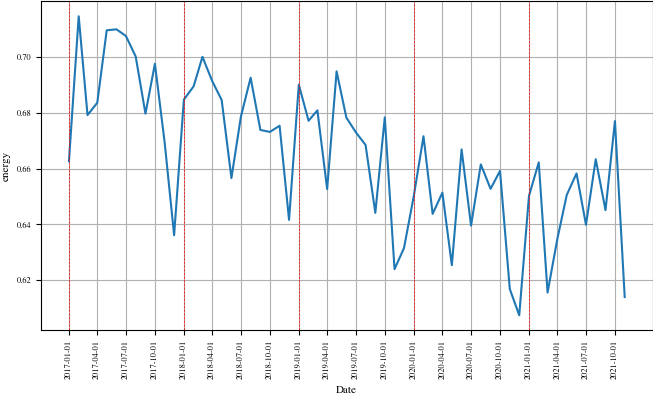

In [86]:
def plot_single_feature(fv_df : pd.DataFrame, feature : str):
    plot_kwargs.update({"column" : "full", "nrows" : 1, "ncols" : 1})

    plt.plot(fv_df.columns,fv_df.loc[feature].values)
    plt.xticks(rotation=90)
    plt.xticks(fv_df.columns[::3])
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.grid()

    # Insert a vline for each new year
    new_years = ('2017-01-01','2018-01-01','2019-01-01','2020-01-01','2021-01-01')
    new_years_ts = [pd.to_datetime(year) for year in new_years]
    for year in new_years_ts:
        plt.axvline(x=year, color='r', linestyle='--', linewidth=0.5)

plot_single_feature(pd.DataFrame(fv_dict["Germany"]), "energy")

In [89]:
residual_dict = {}
for region in fv_dict.keys():
    change_df = pd.DataFrame(fv_dict[region])
    residual_list = []
    for i,j in zip(change_df.columns[:-1],change_df.columns[1:]):
        residual_list.append(change_df[j] - change_df[i])
    residual_list = np.array(residual_list).T
    residual_df = pd.DataFrame(residual_list, columns=change_df.columns[1:], index=change_df.index)
    residual_dict[region] = residual_df